In [195]:
import re
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [220]:
rxnlist = {'r1': 'A + B -> C', 'r2' : 'B + C -> D'}

In [221]:
rxnparam_dict = {'r1': {'kf':1, 'Keq': -1, 'Eaf': 30000, 'Ear': 0, 'Tref_C': 25}, 
                 'r2' : {'kf':1, 'Keq': -1, 'Eaf': 30000, 'Ear': 0, 'Tref_C': 25}}
rxnparam = pd.DataFrame.from_dict(rxnparam_dict, orient = 'index')
rxnparam

,kf,Keq,Eaf,Ear,Tref_C
r1,1,-1,30000,0,25
r2,1,-1,30000,0,25


In [222]:
def stoicoeff(x):
    if '*' in x:
        stoi = (x.split('*')[1], int(x.split('*')[0]))
    else:
        stoi = (x, 1)
    return stoi

In [223]:
stoicoeff('A'), stoicoeff('2*B')

(('A', 1), ('B', 2))

In [224]:
def get_rxnstoi(rxnlist):
    rxnstoi = dict()

    for k, rxn in rxnlist.items():
        rxn2 = re.split('->|=', rxn)
        rxntype = 'eqb' if '=' in rxn else 'fwd'
        reactants = [x.strip() for x in rxn2[0].split('+')]
        products = [x.strip() for x in rxn2[1].split('+')]
        stoi = {stoicoeff(x)[0]: -stoicoeff(x)[1] for x in reactants}
        stoi_products = {stoicoeff(x)[0]: stoicoeff(x)[1] for x in products}
        stoi.update(stoi_products)
        stoi.update({'rxntype': rxntype})
        rxnstoi[k] = stoi
    
    rxnstoi_df = pd.DataFrame.from_dict(rxnstoi, orient = 'index').fillna(0)
    
    return rxnstoi_df

In [225]:
rxnstoi_df = get_rxnstoi(rxnlist)
rxnstoi_df

,A,B,C,rxntype,D
r1,-1.0,-1,1,fwd,0.0
r2,0.0,-1,-1,fwd,1.0


In [226]:
rlist = list(rxnstoi_df.index)

In [227]:
clist = list(rxnstoi_df.drop('rxntype', axis = 1).columns)
stoimat = rxnstoi_df.drop('rxntype', axis = 1).to_numpy().T
print(clist)
print(stoimat)

['A', 'B', 'C', 'D']
[[-1.  0.]
 [-1. -1.]
 [ 1. -1.]
 [ 0.  1.]]


In [228]:
def rate(conc, stoimat, kf, Keq):
    
    ncmp = stoimat.shape[0]
    nrxn = stoimat.shape[1]
    rrate = np.zeros(nrxn)
    for r in range(nrxn):
        # calculate forward reaction rate
        rfstoi = stoimat[:, r].copy()
        rfstoi[rfstoi > 0] = 0
        rf = kf[r] * np.prod(conc ** (-rfstoi))
        # calculate reverse reaction rate
        if Keq[r] > 0:
            rrstoi = stoimat[:, r].copy()
            rrstoi[rrstoi < 0] = 0
            rr = kr[r] / Keq[r] * np.prod(conc ** (rrstoi))
        else:
            rr = 0.0
        # overall reaction rate
        rrate[r] = rf - rr

    dc = np.matmul(stoimat, rrate)
    
    return dc

In [229]:
def simulate(tspan, cinit, T, rxnparam, t_eval = None):
    
    R = 8.314
    
    kf = rxnparam['kf'].values
    Keq = rxnparam['Keq'].values
    Eaf = rxnparam['Eaf'].values
    Ear = rxnparam['Ear'].values
    Tref_C = rxnparam['Tref_C'].values
    
    kf = kf * np.exp((-Eaf / R) * (1/(T + 273) - 1/(Tref_C + 273)))
    Keq = Keq * np.exp((-(Eaf - Ear) / R) * (1/(T + 273) - 1/(Tref_C + 273)))
    rate_lam = lambda t, c: rate(c, stoimat, kf, Keq)
    csol = solve_ivp(rate_lam, tspan, cinit, method = 'BDF', t_eval = t_eval)
    
    return csol

In [230]:
csol = simulate([0, 10], [1, 1, 0, 0], 25, rxnparam)

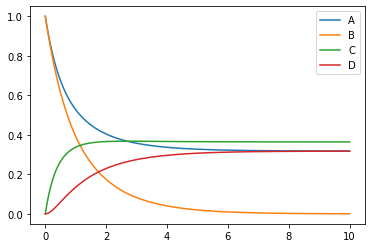

In [231]:
fig, ax = plt.subplots()
ax.plot(csol.t, csol.y[0, :], label = 'A')
ax.plot(csol.t, csol.y[1, :], label = 'B')
ax.plot(csol.t, csol.y[2, :], label = 'C')
ax.plot(csol.t, csol.y[3, :], label = 'D')
ax.legend()